# Clusterización: Extracción de Colores Predominantes en Imágenes
### Itzanami Berlanga Contreras | 07 de Abril del 2024

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd
from skimage import io

## Carga de la Imagenes

- Dimensiones de la imagen:
(512, 512, 3)


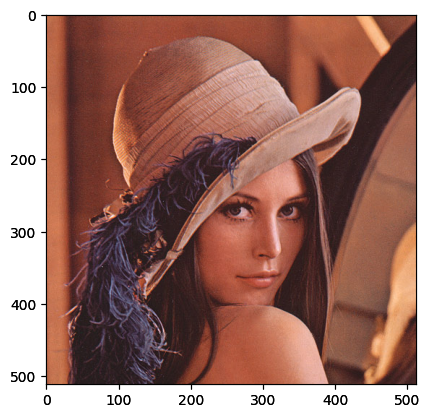

In [3]:
image=io.imread("lena_color.bmp")/255.0 # imread lee las imagenes con los pixeles codificados como enteros 
# en el rango 0-255. Por eso la convertimos a flotante y en el rango 0-1

print("- Dimensiones de la imagen:")
print(image.shape)
im = plt.imshow(image)
ax = plt.axes()
ax.set_facecolor('white')
plt.imshow(image)